In [1]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/white-blood-cells-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'white-blood-cells-dataset' dataset.
Path to dataset files: /kaggle/input/white-blood-cells-dataset


In [3]:
%cd /content/drive/MyDrive/projects/wbc-cnn-knn-classifier

/content/drive/MyDrive/projects/wbc-cnn-knn-classifier


In [33]:
from src.cleaning import create_dataset , relpaths_to_fullpaths

In [5]:
train_df = pd.read_csv("data/splits/train.csv")
val_df = pd.read_csv("data/splits/val.csv")
train_df.head()
val_df.columns

Index(['path', 'label'], dtype='object')

In [6]:
train_paths, train_labels = train_df["path"].values, train_df["label"].values
train_paths = relpaths_to_fullpaths(path,train_paths)
print(type(train_labels))

<class 'numpy.ndarray'>


In [7]:
train_paths[1]

'/kaggle/input/white-blood-cells-dataset/Train/Lymphocyte/95-8-8-2_35_2.jpg'

In [8]:
val_paths,val_labels = val_df["path"].values, val_df["label"].values
val_paths = relpaths_to_fullpaths(path,val_paths)

In [9]:
training_dataset = create_dataset(train_paths,train_labels,True)
validation_dataset = create_dataset(val_paths,val_labels,False)



In [10]:
for images, labels in training_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [11]:
NUM_CLASSES = 5
IMG_SIZE = (224, 224)

In [12]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, #exclude the classification layers from the pretrained model
    weights="imagenet", #preserve the params from the training done on 1m image
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3) #224x244x3
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
base_model.trainable=False #freeze the back bone (only training the head)

In [14]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)) #setting the input settings
x = base_model(inputs, training=False) # x Symbolic Tensor it shows the data the path that it will take while training starting from the input to output going throw the pretrained model and the new classification layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) # regularization
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy", # for multiclassification
    metrics=["accuracy"] # cuz data set is balanced (f1 is it wasnt)
)


In [16]:
import os
os.makedirs("models/finetuned", exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5, restore_best_weights=True #breaks out of the training of the validatrion accuracy score goes down 5 times in a row
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="models/finetuned/best_model.keras",
        monitor="val_accuracy",
        save_best_only=True #auto saves the best epoch
    ),
    tf.keras.callbacks.ReduceLROnPlateau( #reduces learning rate when model stops improving
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
    )
]

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 169s 545ms/step - accuracy: 0.6948 - loss: 0.8321 - val_accuracy: 0.8373 - val_loss: 0.4209 - learning_rate: 0.0010
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 94s 370ms/step - accuracy: 0.8484 - loss: 0.4290 - val_accuracy: 0.9007 - val_loss: 0.3198 - learning_rate: 0.0010
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 92s 361ms/step - accuracy: 0.8827 - loss: 0.3562 - val_accuracy: 0.9002 - val_loss: 0.2731 - learning_rate: 0.0010
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 143s 366ms/step - accuracy: 0.8993 - loss: 0.3008 - val_accuracy: 0.9150 - val_loss: 0.2464 - learning_rate: 0.0010
Epoch 5/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 93s 365ms/step - accuracy: 0.9045 - loss: 0.2825 - val_accuracy: 0.9174 - val_loss: 0.2243 - learning_rate: 0.0010
Epoch 6/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 141s 362ms/step - accuracy: 0.9156 - loss: 0.2593 - val_accuracy: 0.9287 - val_loss: 0.2055 - learning_rate: 0.0010
Epoch 7/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 93s 364ms/step - accuracy: 

In [19]:
base_model.trainable = True

# unfreeze only last 20 layers (default)
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=callbacks
)

model.save("models/finetuned/final_model_finetuned.keras")


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 155s 501ms/step - accuracy: 0.6568 - loss: 1.0792 - val_accuracy: 0.9061 - val_loss: 0.2818 - learning_rate: 1.0000e-05
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 95s 371ms/step - accuracy: 0.8742 - loss: 0.3859 - val_accuracy: 0.9410 - val_loss: 0.1966 - learning_rate: 1.0000e-05
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 95s 372ms/step - accuracy: 0.9103 - loss: 0.2733 - val_accuracy: 0.9474 - val_loss: 0.1646 - learning_rate: 1.0000e-05
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 147s 393ms/step - accuracy: 0.9256 - loss: 0.2343 - val_accuracy: 0.9523 - val_loss: 0.1446 - learning_rate: 1.0000e-05
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 100s 392ms/step - accuracy: 0.9359 - loss: 0.1965 - val_accuracy: 0.9563 - val_loss: 0.1325 - learning_rate: 1.0000e-05
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 101s 397ms/step - accuracy: 0.9372 - loss: 0.1883 - val_accuracy: 0.9577 - val_loss: 0.1223 - learning_rate: 1.0000e-05
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 96

In [20]:
import os
os.makedirs("models/encoder", exist_ok=True)
for layer in model.layers[::-1]:
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        feature_layer_name = layer.name #the layer responsible of the features to vector transformation
        break

encoder = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(feature_layer_name).output, #extract until the layer that return vectors
    name="feature_encoder"
)

encoder.trainable = False #making sure that the weights of the encoder wont change while in another model

encoder.save("models/encoder/feature_encoder.keras")
print("Saved encoder:", encoder.output_shape)

Saved encoder: (None, 1280)


64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       0.90      0.83      0.86       149
           2       0.96      0.98      0.97       486
           3       0.88      0.81      0.85       112
           4       0.98      0.99      0.98      1246

    accuracy                           0.96      2035
   macro avg       0.94      0.92      0.93      2035
weighted avg       0.96      0.96      0.96      2035



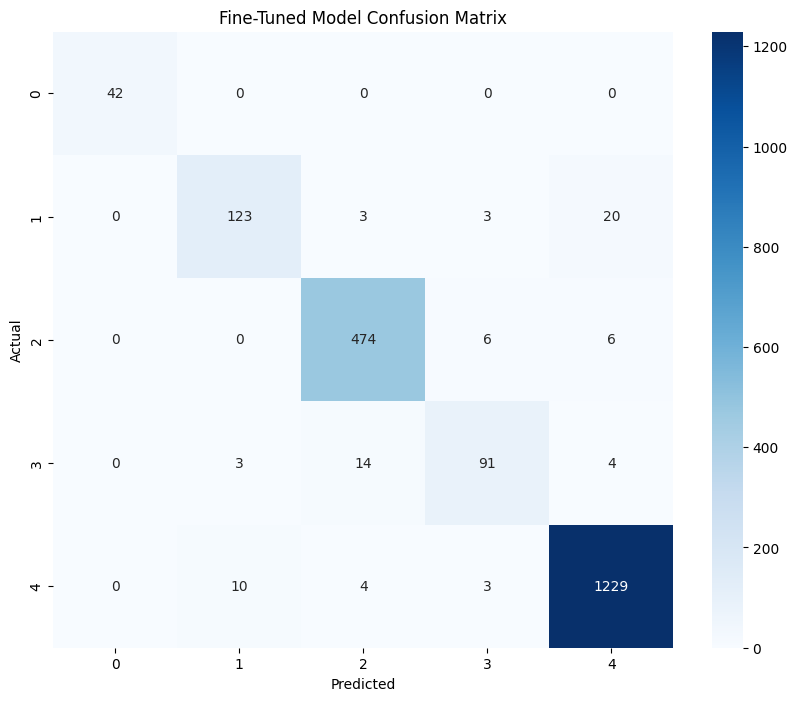

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predictions
y_pred_probs = model.predict(validation_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

# 2. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Fine-Tuned Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("models/finetuned/confusion_matrix.png") #

# 3. Print Report
print(classification_report(y_true, y_pred))

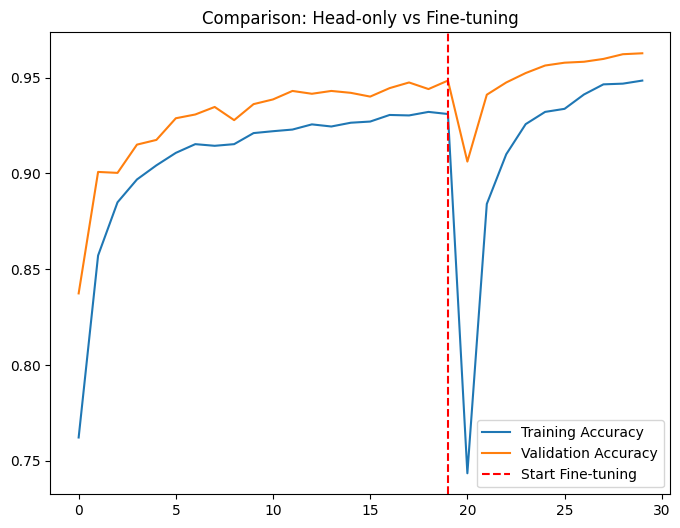

In [25]:

# Combine the accuracy lists
total_acc = history.history['accuracy'] + history_ft.history['accuracy']
total_val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']

# Plotting the "Joint" History
plt.figure(figsize=(8, 6))
plt.plot(total_acc, label='Training Accuracy')
plt.plot(total_val_acc, label='Validation Accuracy')

# Draw a vertical line to show where fine-tuning started
plt.axvline(x=len(history.history['accuracy'])-1, color='r', linestyle='--', label='Start Fine-tuning')

plt.title('Comparison: Head-only vs Fine-tuning')
plt.legend(loc='lower right')
plt.show()


In [28]:
save_path = "models/finetuned//training_plot.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [29]:


# Convert dictionaries to DataFrames
df_head = pd.DataFrame(history.history)
df_ft = pd.DataFrame(history_ft.history)

#'stage' column to distinguish them
df_head['stage'] = 'head_only'
df_ft['stage'] = 'fine_tuning'

#Combine
full_history_df = pd.concat([df_head, df_ft], ignore_index=True)


full_history_df.to_csv("models/finetuned/training_history.csv", index=False)

print("History saved! Columns available:", full_history_df.columns.tolist())

History saved! Columns available: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate', 'stage']


In [30]:
import json

# Define your hyperparameters in a dictionary
hyperparams = {
    "architecture": "EfficientNetB0",
    "optimizer": "Adam",
    "initial_lr": 1e-3,
    "fine_tune_lr": 1e-5,
    "batch_size": 32,
    "epochs_head": 20,
    "epochs_finetune": 10,
    "loss_func": "sparse_categorical_crossentropy"
}

# Save them to a JSON file
with open("models/finetuned/hyperparams.json", "w") as f:
    json.dump(hyperparams, f, indent=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


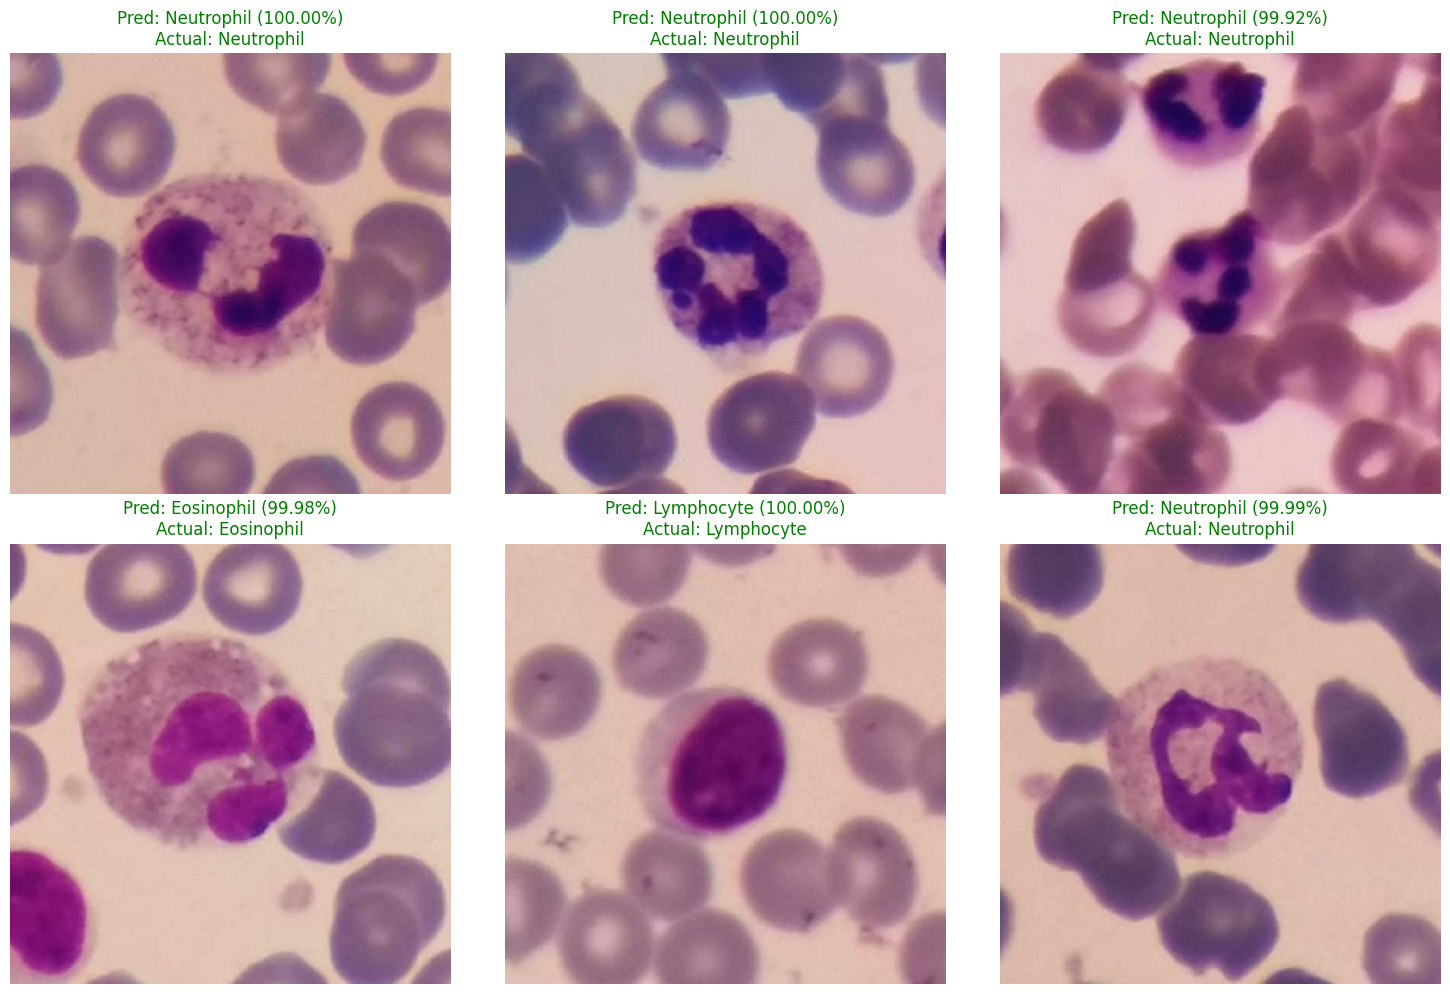

In [34]:
def visualize_predictions(model, dataset, class_names, num_images=6):
    plt.figure(figsize=(15, 10))
    # Get one batch from the dataset
    for images, labels in dataset.take(1):
        preds = model.predict(images)

        for i in range(num_images):
            plt.subplot(2, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            pred_class = class_names[np.argmax(preds[i])]
            actual_class = class_names[labels[i]]
            prob = np.max(preds[i])

            color = 'green' if pred_class == actual_class else 'red'

            plt.title(f"Pred: {pred_class} ({prob:.2%})\nActual: {actual_class}", color=color)
            plt.axis("off")
    plt.tight_layout()
    plt.show()
class_names = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
visualize_predictions(model, validation_dataset, class_names)